# GTI DIRINT Examples

This notebook shows a few examples of the pvlib python implementation of the GTI DIRINT algorithm.

Authors: Will Holmgren (@wholmgren), University of Arizona (2017, 2018).

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = 8, 5
mpl.rcParams['figure.dpi'] = 100

import pandas as pd
import numpy as np

import pvlib
from pvlib.location import Location
from pvlib.pvsystem import PVSystem
from pvlib.modelchain import ModelChain
from pvlib.tracking import SingleAxisTracker
from pvlib.tools import cosd

pvlib.__version__

'0.5.2+63.gbe384b7'

In [2]:
from importlib import reload

Use a clear sky algorithm to generate some POA data.

In [3]:
freq = '5min'  # 5min is the finest resolution tested in Marion 2015

times = pd.DatetimeIndex(start='20160606', end='20160607', tz='America/Phoenix', freq=freq)

In [4]:
location = Location(32.2, -110.9, altitude=700)

In [5]:
pressure = pvlib.atmosphere.alt2pres(location.altitude)

In [6]:
solpos = location.get_solarposition(times)

In [7]:
cs = location.get_clearsky(times, solar_position=solpos)

In [8]:
dni, ghi, dhi = cs['dni'], cs['ghi'], cs['dhi']

In [9]:
solar_zenith, solar_azimuth = solpos['zenith'], solpos['azimuth']

In [10]:
surface_tilt = 40
surface_azimuth = 180
system = PVSystem(surface_tilt=surface_tilt, surface_azimuth=surface_azimuth)

In [11]:
aoi = system.get_aoi(solar_zenith, solar_azimuth)

In [12]:
# note that this method will use the haydavies transposition model by default,
# however the gti_dirint function will use perez by default.
all_irrad = system.get_irradiance(solar_zenith, solar_azimuth, dni, ghi, dhi)

In [13]:
poa_global = all_irrad['poa_global']

Text(0,0.5,'AOI (deg)')

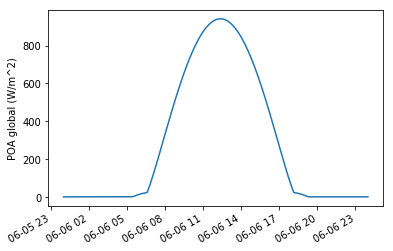

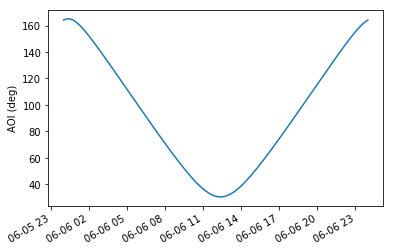

In [14]:
poa_global.plot()
plt.ylabel('POA global (W/m^2)')

plt.figure()
aoi.plot()
plt.ylabel('AOI (deg)')

In [15]:
aoi_lt_90 = aoi < 90
month = 6
color = ['b', 'g', 'r']

In [16]:
pvlib = reload(pvlib)
pvlib.irradiance = reload(pvlib.irradiance)

In [17]:
temp_dew = pd.Series(0, index=aoi.index)
model_perez = 'phoenix1988'

In [18]:
gti_dirint_out = pvlib.irradiance.gti_dirint(
    poa_global, aoi, solar_zenith, solar_azimuth,
    times, surface_tilt, surface_azimuth,
    pressure=pressure,
    use_delta_kt_prime=True, temp_dew=temp_dew, albedo=.25,
    model='perez', model_perez=model_perez,
    calculate_gt_90=True, max_iterations=30)

Text(0.5,1,'Month=6. GTI DIRINT ghi (solid) vs. Original ghi (dashed)')

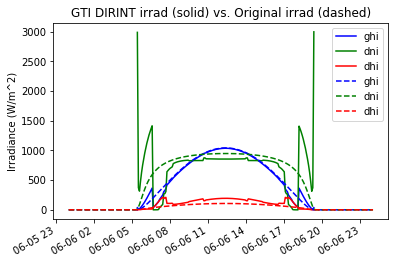

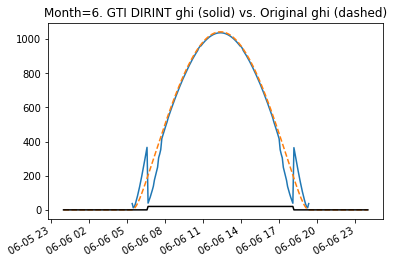

In [19]:
fig, ax = plt.subplots()
gti_dirint_out.plot(ax=ax, color=color)
cs.plot(ax=ax, ls='--', color=color)
ax.set_ylabel('Irradiance (W/m^2)')
ax.set_title('GTI DIRINT irrad (solid) vs. Original irrad (dashed)')

fig, ax = plt.subplots()
gti_dirint_out['ghi'].plot(ax=ax)
cs.loc[gti_dirint_out.index]['ghi'].plot(ax=ax, ls='--')
(aoi_lt_90 * 20).loc[gti_dirint_out.index].plot(color='k')
ax.set_title('Month={}. GTI DIRINT ghi (solid) vs. Original ghi (dashed)'.format(month))

In [20]:
best_ghi, best_dni, best_dhi, best_kt_prime, all_irrad, poa_global_i, kt, kt_prime, best_diff = pvlib.irradiance._gti_dirint_lt_90(
    poa_global, aoi, aoi_lt_90, solar_zenith, solar_azimuth,
    times, surface_tilt, surface_azimuth, pressure=pressure,
    use_delta_kt_prime=True, temp_dew=temp_dew, albedo=.25,
    model='perez', model_perez=model_perez,
    max_iterations=30, debug=True)

gti_dirint_out = pd.DataFrame(dict(zip(('ghi', 'dni', 'dhi'), (best_ghi, best_dni, best_dhi))))

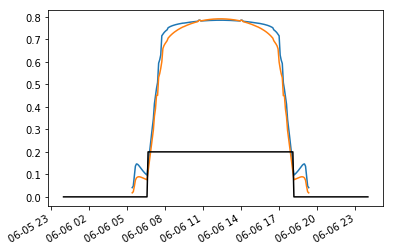

In [21]:
best_kt_prime.plot()
kt.plot()
(aoi_lt_90 * .20).loc[gti_dirint_out.index].plot(color='k')

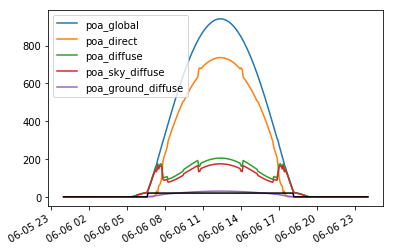

In [22]:
all_irrad.plot()
(aoi_lt_90 * 20).loc[gti_dirint_out.index].plot(color='k')

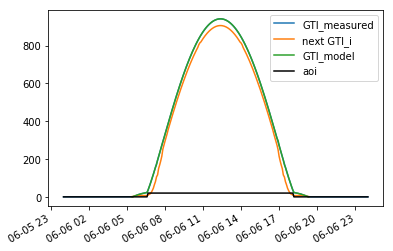

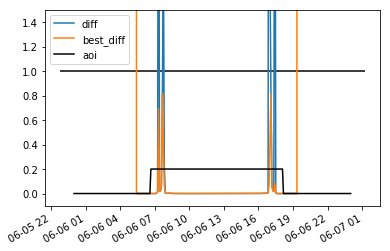

In [23]:
fig, ax = plt.subplots()
poa_global.plot(label='GTI_measured')
poa_global_i.plot(label='next GTI_i')
all_irrad['poa_global'].plot(label='GTI_model')
(aoi_lt_90 * 20).loc[gti_dirint_out.index].plot(color='k')
ax.legend()

fig, ax = plt.subplots()
(all_irrad['poa_global'] - poa_global).abs().plot(label='diff')
best_diff.plot(label='best_diff')
(aoi_lt_90 * .20).loc[gti_dirint_out.index].plot(color='k')
ax.set_ylim(-0.1, 1.5)
ax.hlines(1, *ax.get_xlim())
ax.legend()

Text(0.5,1,'Month=6. GTI DIRINT ghi (solid) vs. Original ghi (dashed)')

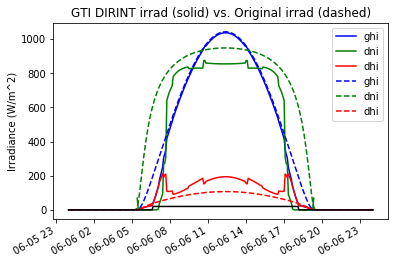

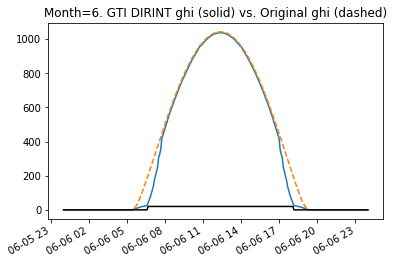

In [24]:
fig, ax = plt.subplots()
gti_dirint_out.plot(ax=ax, color=color)
cs.plot(ax=ax, ls='--', color=color)
(aoi_lt_90 * 20).loc[gti_dirint_out.index].plot(color='k')
ax.set_ylabel('Irradiance (W/m^2)')
ax.set_title('GTI DIRINT irrad (solid) vs. Original irrad (dashed)')

fig, ax = plt.subplots()
gti_dirint_out['ghi'].plot(ax=ax)
cs.loc[gti_dirint_out.index]['ghi'].plot(ax=ax, ls='--')
(aoi_lt_90 * 20).loc[gti_dirint_out.index].plot(color='k')
ax.set_title('Month={}. GTI DIRINT ghi (solid) vs. Original ghi (dashed)'.format(month))

Any warnings show the points for which the iterative algorithm failed to converge in the AOI < 90 case.

Looks ok overall, but not good near AOI = 90.

Text(0.5,1,'GTI DIRINT irrad (solid) vs. Original irrad (dashed)')

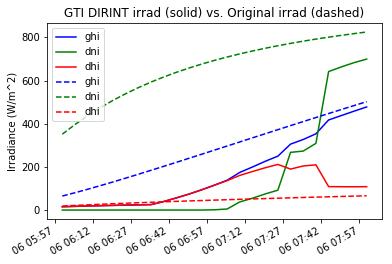

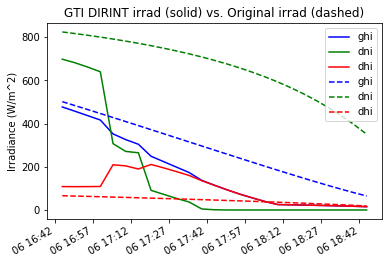

In [25]:
fig, ax = plt.subplots()
startend = '06:00', '08:00'
gti_dirint_out.between_time(*startend).plot(ax=ax, color=color)
cs.between_time(*startend).plot(ax=ax, ls='--', color=color)
ax.set_ylabel('Irradiance (W/m^2)')
ax.set_title('GTI DIRINT irrad (solid) vs. Original irrad (dashed)')

fig, ax = plt.subplots()
startend = '16:45', '18:45'
gti_dirint_out.between_time(*startend).plot(ax=ax, color=color)
cs.between_time(*startend).plot(ax=ax, ls='--', color=color)
ax.set_ylabel('Irradiance (W/m^2)')
ax.set_title('GTI DIRINT irrad (solid) vs. Original irrad (dashed)')

The model struggles for AOI between 80 and 90 degrees.

Run the model in only the middle of the day.

In [26]:
startend = '09:00', '15:00'
gti_dirint_out = pvlib.irradiance.gti_dirint(
    poa_global.between_time(*startend), aoi.between_time(*startend), 
    solar_zenith.between_time(*startend), solar_azimuth.between_time(*startend),
    solar_zenith.between_time(*startend).index, surface_tilt, surface_azimuth,
    pressure=pressure,
    use_delta_kt_prime=True, temp_dew=None, albedo=.25,
    model='perez', model_perez='allsitescomposite1990',
    calculate_gt_90=True, max_iterations=30)

Text(0.5,1,'Month=6. GTI DIRINT ghi (solid) vs. Original ghi (dashed)')

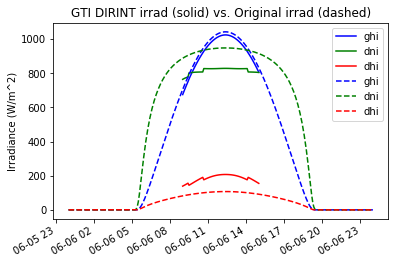

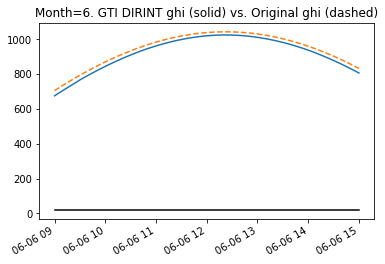

In [27]:
fig, ax = plt.subplots()
gti_dirint_out.plot(ax=ax, color=color)
cs.plot(ax=ax, ls='--', color=color)
ax.set_ylabel('Irradiance (W/m^2)')
ax.set_title('GTI DIRINT irrad (solid) vs. Original irrad (dashed)')

fig, ax = plt.subplots()
gti_dirint_out['ghi'].plot(ax=ax)
cs.loc[gti_dirint_out.index]['ghi'].plot(ax=ax, ls='--')
(aoi_lt_90 * 20).loc[gti_dirint_out.index].plot(color='k')
ax.set_title('Month={}. GTI DIRINT ghi (solid) vs. Original ghi (dashed)'.format(month))

Repeat for summer solstice, fall equinox, winter solstice.

In [28]:
times_jun = pd.DatetimeIndex(start='20160621', end='20160622', tz='America/Phoenix', freq=freq)
times_sep = pd.DatetimeIndex(start='20160921', end='20160922', tz='America/Phoenix', freq=freq)
times_dec = pd.DatetimeIndex(start='20161221', end='20161222', tz='America/Phoenix', freq=freq)

times = times_jun.append(times_sep).append(times_dec)

In [29]:
solpos = location.get_solarposition(times)

In [30]:
cs = location.get_clearsky(times, solar_position=solpos)

In [31]:
dni, ghi, dhi = cs['dni'], cs['ghi'], cs['dhi']

In [32]:
solar_zenith, solar_azimuth = solpos['zenith'], solpos['azimuth']

In [33]:
surface_tilt = 40
surface_azimuth = 180
system = PVSystem(surface_tilt=surface_tilt, surface_azimuth=surface_azimuth)

In [34]:
aoi = system.get_aoi(solar_zenith, solar_azimuth)

In [35]:
# note that this method will use the haydavies transposition model by default,
# however the gti_dirint function will use perez by default.
all_irrad = system.get_irradiance(solar_zenith, solar_azimuth, dni, ghi, dhi)

In [36]:
poa_global = all_irrad['poa_global']

In [37]:
aoi_lt_90 = aoi < 90

In [38]:
gti_dirint_out = pvlib.irradiance.gti_dirint(
    poa_global, aoi, solar_zenith, solar_azimuth,
    times, surface_tilt, surface_azimuth,
    pressure=pressure,
    use_delta_kt_prime=True, temp_dew=None, albedo=.25,
    model='perez', model_perez='allsitescomposite1990',
    calculate_gt_90=True, max_iterations=30)

/Users/holmgren/git_repos/pvlib2/pvlib-python/pvlib/irradiance.py:1951: RuntimeWarning: 40 points failed to converge after 30 iterations. best_diff:
2016-09-21 06:20:00-07:00       2.715976
2016-09-21 18:15:00-07:00       6.174917
2016-12-21 06:10:00-07:00    9999.000000
2016-12-21 06:15:00-07:00    9999.000000
2016-12-21 06:20:00-07:00    9999.000000
2016-12-21 06:25:00-07:00    9999.000000
2016-12-21 06:30:00-07:00    9999.000000
2016-12-21 06:35:00-07:00    9999.000000
2016-12-21 06:40:00-07:00    9999.000000
2016-12-21 06:45:00-07:00    9999.000000
2016-12-21 06:50:00-07:00    9999.000000
2016-12-21 06:55:00-07:00    9999.000000
2016-12-21 07:00:00-07:00    9999.000000
2016-12-21 07:05:00-07:00    9999.000000
2016-12-21 07:10:00-07:00    9999.000000
2016-12-21 07:15:00-07:00    9999.000000
2016-12-21 07:20:00-07:00    9999.000000
2016-12-21 07:25:00-07:00    9999.000000
2016-12-21 07:30:00-07:00     224.255280
2016-12-21 09:45:00-07:00       1.623382
2016-12-21 09:50:00-07:00      

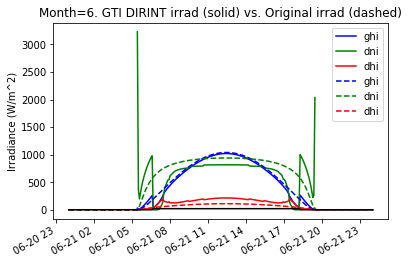

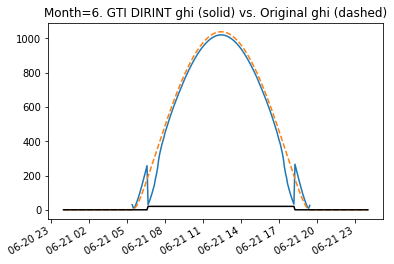

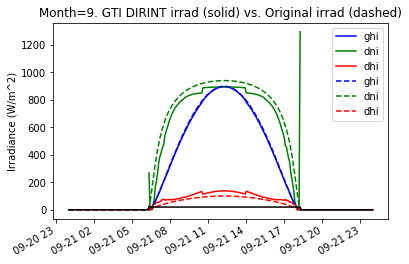

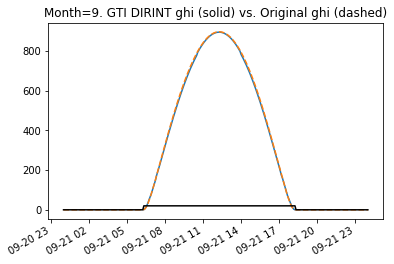

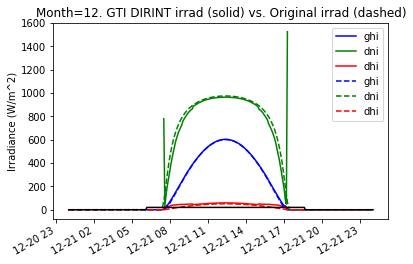

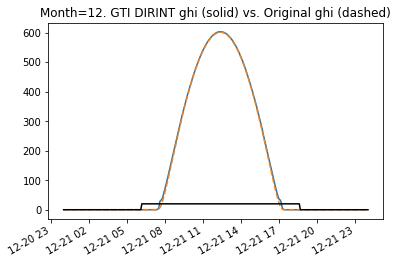

In [39]:
for month, data in gti_dirint_out.groupby(times.month):
    fig, ax = plt.subplots()
    data.plot(ax=ax, color=color)
    cs.loc[data.index].plot(ax=ax, ls='--', color=color)
    (aoi_lt_90 * 20).loc[data.index].plot(color='k')  # please excuse the sloppy reuse of the axis
    ax.set_ylabel('Irradiance (W/m^2)')
    ax.set_title('Month={}. GTI DIRINT irrad (solid) vs. Original irrad (dashed)'.format(month))

    fig, ax = plt.subplots()
    data['ghi'].plot(ax=ax)
    cs.loc[data.index]['ghi'].plot(ax=ax, ls='--')
    (aoi_lt_90 * 20).loc[data.index].plot(color='k')
    ax.set_title('Month={}. GTI DIRINT ghi (solid) vs. Original ghi (dashed)'.format(month))

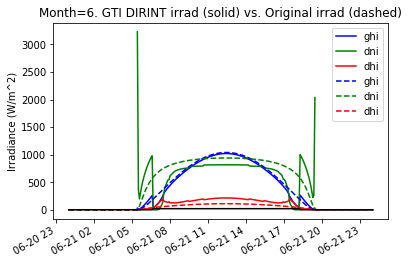

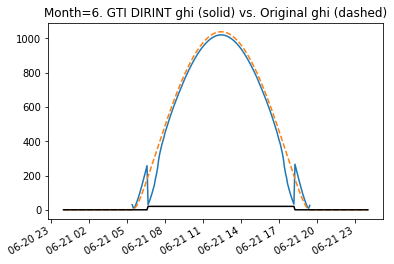

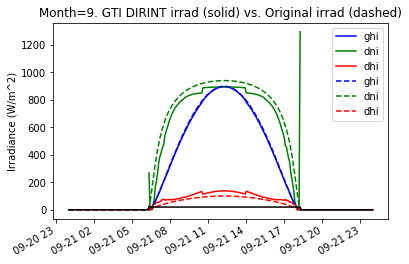

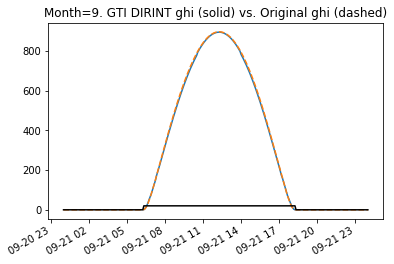

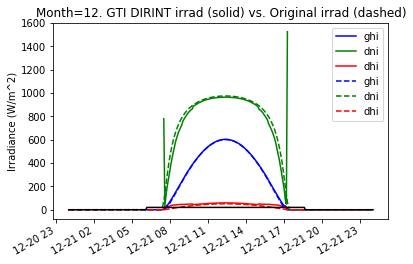

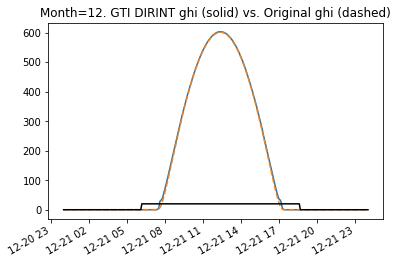

In [40]:
for month, data in gti_dirint_out.groupby(times.month):
    fig, ax = plt.subplots()
    data.plot(ax=ax, color=color)
    cs.loc[data.index].plot(ax=ax, ls='--', color=color)
    (aoi_lt_90 * 20).loc[data.index].plot(color='k')  # please excuse the sloppy reuse of the axis
    ax.set_ylabel('Irradiance (W/m^2)')
    ax.set_title('Month={}. GTI DIRINT irrad (solid) vs. Original irrad (dashed)'.format(month))

    fig, ax = plt.subplots()
    data['ghi'].plot(ax=ax)
    cs.loc[data.index]['ghi'].plot(ax=ax, ls='--')
    (aoi_lt_90 * 20).loc[data.index].plot(color='k')
    ax.set_title('Month={}. GTI DIRINT ghi (solid) vs. Original ghi (dashed)'.format(month))